# Modeling the COVID-19 Reproduction Metric using Gaussian Processes


Let's set some setting for this Jupyter Notebook.

In [19]:
%matplotlib inline   
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'    
    
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [12, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Step 1: Prepare the data
We shall use **HISTORIC STATE DAILY** data from **https://covidtracking.com/api/v1/states/daily.csv**

In [20]:
states = pd.read_csv('data/states.csv', 
                     parse_dates=['date'],
                     index_col=['state', 'date']).sort_index()

In [21]:
states.head(n=6)

positive  negative  pending  hospitalizedCurrently  \
state date                                                             
AK    2020-03-06       0.0       8.0      1.0                    NaN   
      2020-03-07       0.0      12.0      2.0                    NaN   
      2020-03-08       0.0      14.0      6.0                    NaN   
      2020-03-09       0.0      23.0      9.0                    NaN   
      2020-03-10       0.0      23.0      9.0                    NaN   
      2020-03-11       0.0      46.0     14.0                    NaN   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
AK    2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   
      2020-03-09                     NaN             NaN              NaN   
      2020-03-10                     NaN             NaN              NaN   
      2020-03-11                     NaN             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
AK    2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   
      2020-03-09                    NaN                     NaN        NaN   
      2020-03-10                    NaN                     NaN        NaN   
      2020-03-11                    NaN                     NaN        NaN   

                  ... hospitalized total totalTestResults posNeg  fips  \
state date        ...                                                    
AK    2020-03-06  ...          NaN     9                8      8     2   
      2020-03-07  ...          NaN    14               12     12     2   
      2020-03-08  ...          NaN    20               14     14     2   
      2020-03-09  ...          NaN    32               23     23     2   
      2020-03-10  ...          NaN    32               23     23     2   
      2020-03-11  ...          NaN    60               46     46     2   

                  deathIncrease  hospitalizedIncrease  negativeIncrease  \
state date                                                                
AK    2020-03-06            NaN                   NaN               NaN   
      2020-03-07            0.0                   0.0               4.0   
      2020-03-08            0.0                   0.0               2.0   
      2020-03-09            0.0                   0.0               9.0   
      2020-03-10            0.0                   0.0               0.0   
      2020-03-11            0.0                   0.0              23.0   

                  positiveIncrease  totalTestResultsIncrease  
state date                                                    
AK    2020-03-06               NaN                       NaN  
      2020-03-07               0.0                       4.0  
      2020-03-08               0.0                       2.0  
      2020-03-09               0.0                       9.0  
      2020-03-10               0.0                       0.0  
      2020-03-11               0.0                      23.0  

[6 rows x 25 columns]

In [22]:
state = "CA"
states.xs(state).head(n=6)

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,
2020-03-04,53.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,515,515,515,6,NaN,NaN,NaN,NaN,NaN
2020-03-05,53.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,515,515,515,6,0.0,0.0,0.0,0.0,0.0
2020-03-06,60.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,522,522,522,6,0.0,0.0,0.0,7.0,7.0
2020-03-07,69.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,531,531,531,6,0.0,0.0,0.0,9.0,9.0
2020-03-08,88.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,550,550,550,6,0.0,0.0,0.0,19.0,19.0
2020-03-09,114.0,690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,804,804,804,6,0.0,0.0,228.0,26.0,254.0


In [23]:
confirmed = states.xs(state).positive.diff().dropna()
confirmed.head(n=5)
confirmed = pd.DataFrame(confirmed).reset_index()
confirmed.head(n=5)
confirmed.to_csv('data/confirmed.csv')

date
2020-03-05     0.0
2020-03-06     7.0
2020-03-07     9.0
2020-03-08    19.0
2020-03-09    26.0
Name: positive, dtype: float64

,date,positive
0,2020-03-05,0.0
1,2020-03-06,7.0
2,2020-03-07,9.0
3,2020-03-08,19.0
4,2020-03-09,26.0


In [24]:
onset = pd.read_csv('data/onset.csv', parse_dates=['date'])
onset

,Unnamed: 0,date,onset
0,0,2019-12-31,0.000000
1,1,2020-01-01,0.001697
2,2,2020-01-02,0.002182
3,3,2020-01-03,0.004607
4,4,2020-01-04,0.006305
...,...,...,...
142,142,2020-05-21,511.864452
143,143,2020-05-22,355.491271
144,144,2020-05-23,208.181377
145,145,2020-05-24,91.134093


In [25]:
adjusted = pd.read_csv('data/adjusted_onset.csv', parse_dates=['date'])
adjusted

,Unnamed: 0,date,adjusted_onset
0,0,2019-12-31,0.000000
1,1,2020-01-01,0.001697
2,2,2020-01-02,0.002182
3,3,2020-01-03,0.004607
4,4,2020-01-04,0.006305
...,...,...,...
142,142,2020-05-21,2067.511263
143,143,2020-05-22,2019.347107
144,144,2020-05-23,1960.136986
145,145,2020-05-24,1879.185000


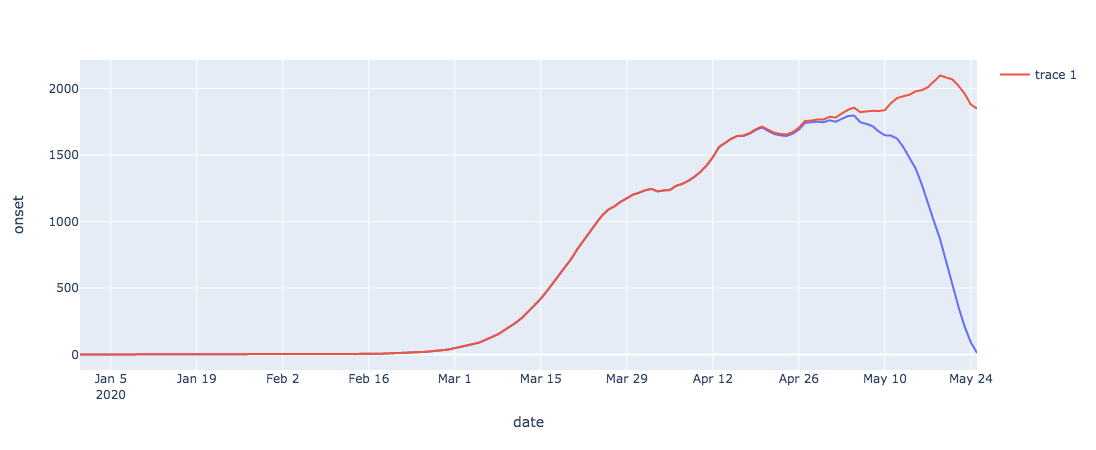

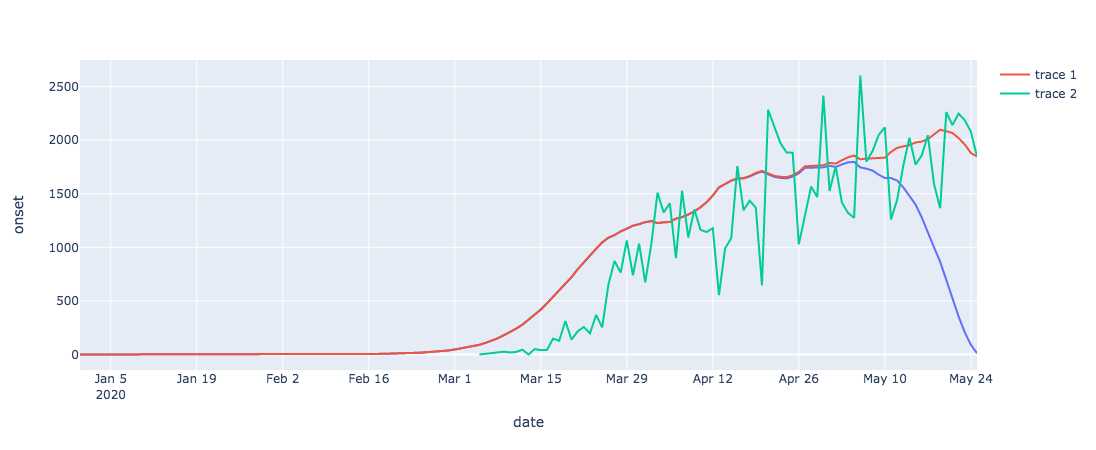

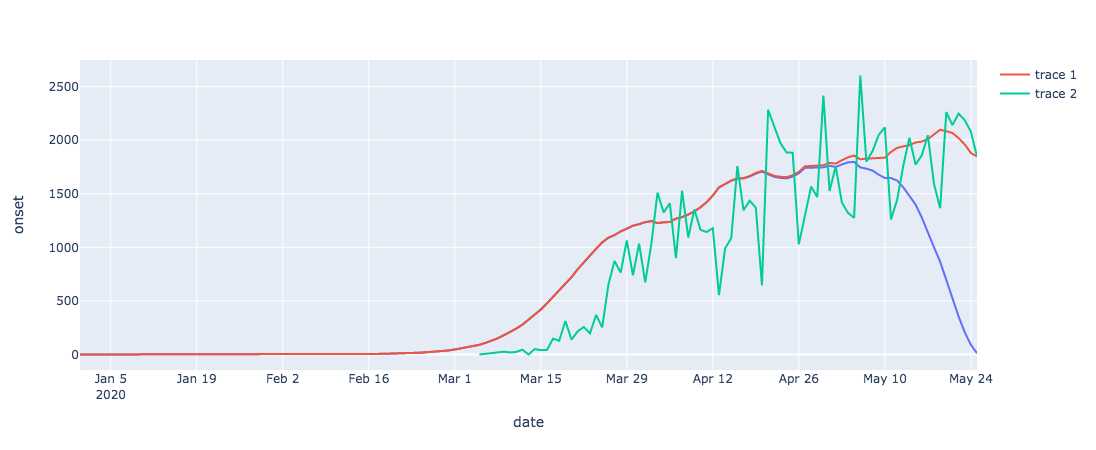

In [26]:
fig = px.line(data_frame=onset, x="date", y="onset")
fig.add_scatter(x=adjusted.date, y=adjusted.adjusted_onset, mode='lines')
fig.add_scatter(x=confirmed.date, y=confirmed.positive, mode='lines')
fig.show()

In [27]:
cumulative_p_delay = pd.read_csv('data/cumulative_p_delay.csv')
cumulative_p_delay

,Unnamed: 0,cumulative_p_delay
0,0,1.000000
1,1,1.000000
2,2,1.000000
3,3,1.000000
4,4,1.000000
...,...,...
142,142,0.247575
143,143,0.176043
144,144,0.106208
145,145,0.048497


In [28]:
X_shape = len(onset) - 1

# The inputs to the GP, they must be arranged as a column vector
X = np.arange(X_shape)[:, None]
X.shape

(146, 1)

In [29]:
# The observed data
y = onset.onset.round().values[1:]
y.shape

(146,)

In [30]:
z = onset["onset"].values[:-1]
z.shape

(146,)

In [31]:
w = cumulative_p_delay["cumulative_p_delay"][:-1]
w.shape

(146,)

In [32]:
inferred_yesterday = onset["onset"].values[:-1] / cumulative_p_delay["cumulative_p_delay"][:-1]

In [33]:
inferred_yesterday.shape

(146,)

In [34]:
expected_today = inferred_yesterday * cumulative_p_delay["cumulative_p_delay"][:-1] 

In [35]:
expected_today.shape

(146,)

## Step 2: Instantiate a model

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [36]:
with pm.Model() as rt_model:
    
    # specify the priors
    length_scale = pm.Gamma("length_scale", alpha = 2, beta = 0.5)
    signal_variance = pm.HalfCauchy("signal_variance", beta = 5)
    noise_variance = pm.HalfCauchy("noise_variance", beta = 5)
        
    # specify the kernel function
    cov = signal_variance**2 * pm.gp.cov.ExpQuad(1, length_scale)
        
    # specify the mean function
    mean_function = pm.gp.mean.Zero()
    
    # specify the gp
    gp = pm.gp.Latent(mean_func=mean_function, cov_func = cov)
    
    # specify the prior over the latent function
    theta = gp.prior("theta", X = X) 
    
    # Let the serial interval be a random variable and calculate r_t
    serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
    gamma = 1.0 / serial_interval
    r_t = pm.Deterministic('r_t', theta / gamma + 1)

    inferred_yesterday = onset["onset"].values[:-1] / cumulative_p_delay["cumulative_p_delay"][:-1]
    expected_today = inferred_yesterday * cumulative_p_delay["cumulative_p_delay"][:-1] * pm.math.exp(theta)

    # Ensure cases stay above zero for poisson
    mu = pm.math.maximum(.1, expected_today)
    
    # specify the likelihood
    observed_cases = pm.Poisson("observed_cases", mu = mu, observed = y)

## Step 3: Perform Inference

In [37]:
# sample from the posterior
with rt_model:     
    posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_rotated_, noise_variance, signal_variance, length_scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 738.84draws/s]


## Step 4: Diagnose convergence

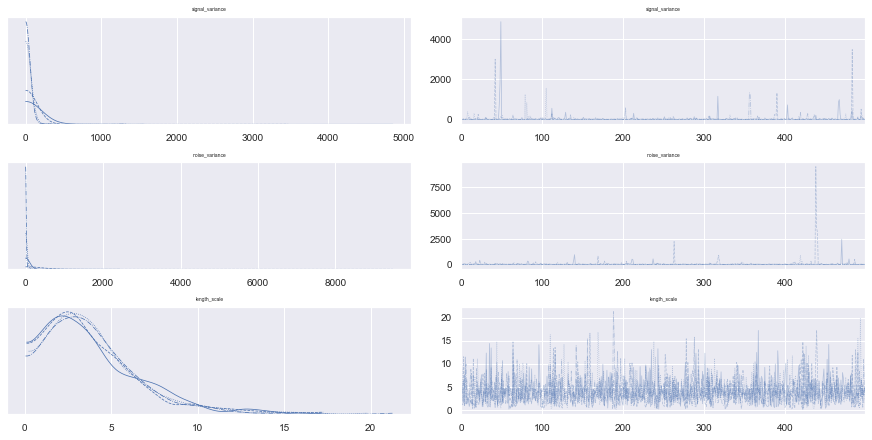

In [38]:
pm.traceplot(posterior, varnames=["signal_variance", "noise_variance", "length_scale"]);

In [39]:
pm.gelman_rubin(posterior, varnames=["signal_variance", "noise_variance", "length_scale"])

<xarray.Dataset>
Dimensions:          ()
Data variables:
    signal_variance  float64 1.003
    noise_variance   float64 0.9995
    length_scale     float64 1.003

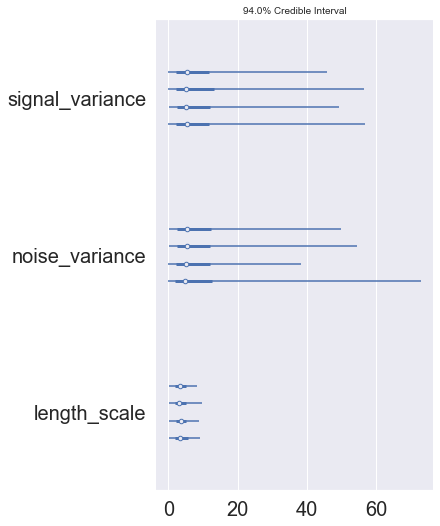

In [40]:
pm.forestplot(posterior, varnames=["signal_variance", "noise_variance", "length_scale"]);

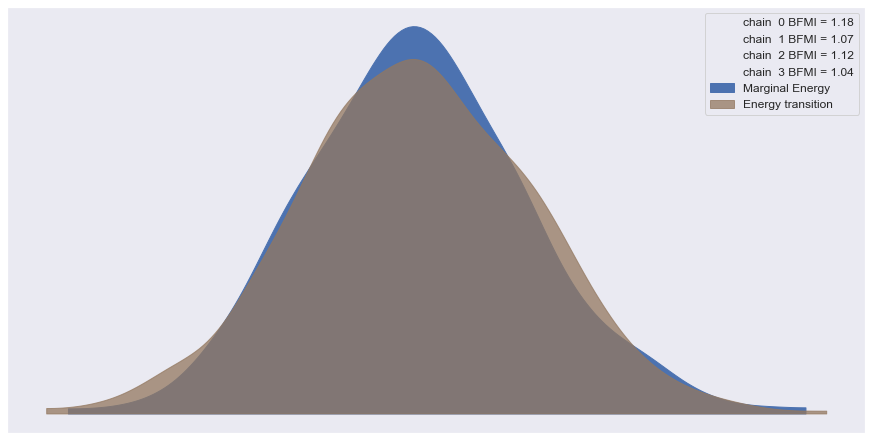

In [41]:
pm.energyplot(posterior)

## Step 5: Critize the model

In [42]:
pm.summary(posterior, varnames=["signal_variance", "noise_variance", "length_scale"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
signal_variance,27.685,178.687,0.002,52.693,4.920,3.480,1319.0,1319.0,2448.0,1081.0,1.0
noise_variance,27.975,253.932,0.012,53.814,8.322,5.886,931.0,931.0,2457.0,1216.0,1.0
length_scale,3.958,2.803,0.074,8.931,0.050,0.045,3146.0,1923.0,2973.0,1277.0,1.0


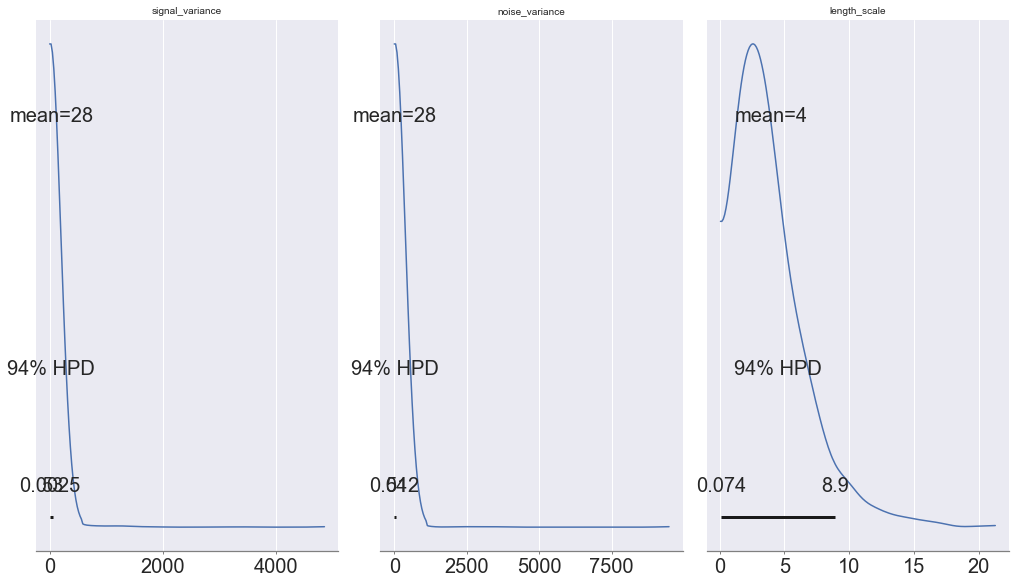

In [43]:
pm.plot_posterior(posterior, varnames=["signal_variance", "noise_variance", "length_scale"], 
                 figsize = [14, 8]);

Text(0.5, 0, 'Inputs, X')

Text(0, 0.5, 'Outputs, Y')

Text(0.5, 1.0, 'Posterior distribution of $f(x)$ at the observed values')

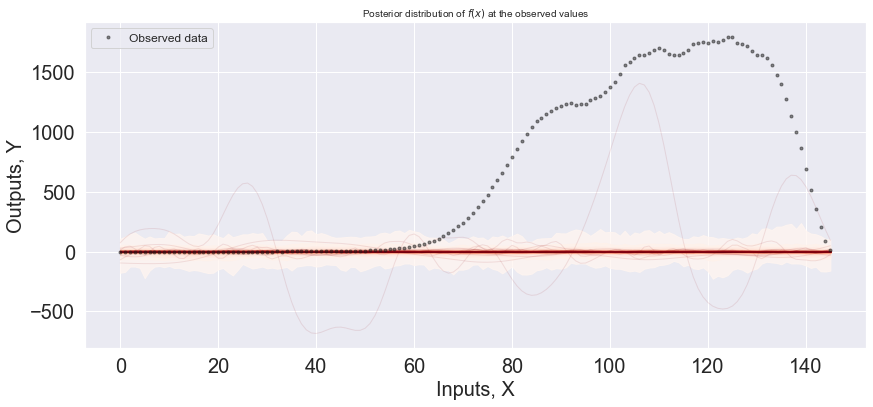

In [44]:
# plot the results
fig = plt.figure(figsize = (14, 6))
ax = fig.gca()

# plot the samples of the gp posterior
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, posterior["theta"], X)

# plot the data and the true function
plt.plot(X, y, "ok", ms = 3, alpha = 0.5, label = "Observed data")

# axis labels and title
plt.xlabel("Inputs, X"); plt.ylabel("Outputs, Y")
plt.title("Posterior distribution of $f(x)$ at the observed values")
plt.legend()

## Step 6: Use the model for prediction

In [45]:
# prepare test dataset
# 30 new values from x=147 to x=177
n_new = 30
X_new = np.arange(start=147, stop=177)[:,None]

In [46]:
X_new

array([[147],
       [148],
       [149],
       [150],
       [151],
       [152],
       [153],
       [154],
       [155],
       [156],
       [157],
       [158],
       [159],
       [160],
       [161],
       [162],
       [163],
       [164],
       [165],
       [166],
       [167],
       [168],
       [169],
       [170],
       [171],
       [172],
       [173],
       [174],
       [175],
       [176]])

In [47]:
# extend the model by adding the GP conditional distribution so as to predict at test data
with rt_model:
    f_pred = gp.conditional("f_pred", X_new)

In [48]:
# sample from the GP conditional posterior
with rt_model:
    posterior_pred = pm.sample_ppc(posterior, vars = [f_pred], samples = 200)

100%|██████████| 200/200 [00:01<00:00, 116.39it/s]


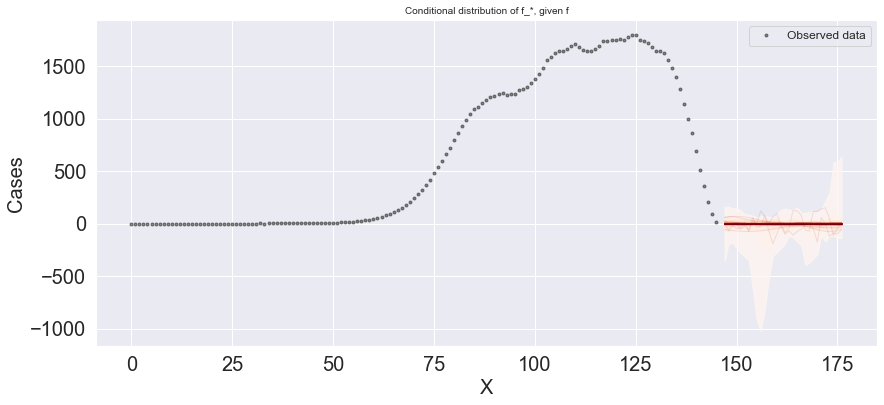

In [51]:
# plot the results
fig = plt.figure(figsize=(14,6)); ax = fig.gca()
plot_gp_dist(ax, posterior_pred["f_pred"], X_new,);
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("Cases");
plt.title("Conditional distribution of f_*, given f"); plt.legend();